In [1]:
!pip install torchvision torchdata

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [2]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
import torch.optim as optim

In [3]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 1024
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 897513.26it/s] 


Extracting /root/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134135.87it/s]


Extracting /root/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:03<00:00, 544116.40it/s]


Extracting /root/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5624602.53it/s]


Extracting /root/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.Size([1024, 1, 28, 28])


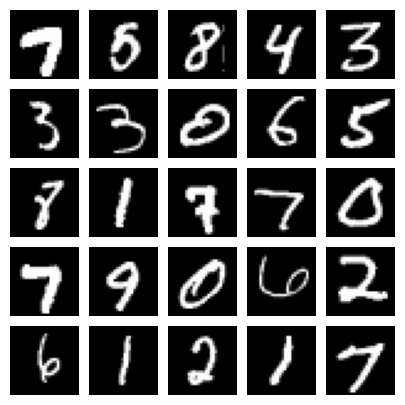

In [5]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = next(dataiter)

print(image[0].shape)
x_dim = 28 * 28

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [6]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=100, device=device):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
          nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          # Layer: Flatten
          nn.Flatten(1),
          # (batch_size, #color, w, h) => (batch_size, )
          # Linear Layer: Equating to Latent
          nn.Linear(196, latent_dim)
        )

        # latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.Linear(latent_dim, 196),
            nn.Unflatten(1, (4, 7, 7)),
            nn.ConvTranspose2d(4, 8,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)

        mean = self.mean_layer(x)
        logvar = self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, log_var)
        x_hat = self.decode(z)
        return x_hat, mean, log_var

In [7]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [8]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [9]:
def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(x.size(0), 1, 28, 28).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

train(model, optimizer, epochs=20, device=device)

	Epoch 1 	Average Loss:  336.1171567193393
	Epoch 2 	Average Loss:  222.19629300873856
	Epoch 3 	Average Loss:  206.14215061582368
	Epoch 4 	Average Loss:  198.07192453844794
	Epoch 5 	Average Loss:  194.91759872436523
	Epoch 6 	Average Loss:  192.2704762425916
	Epoch 7 	Average Loss:  189.47095647351495
	Epoch 8 	Average Loss:  186.80125848178207
	Epoch 9 	Average Loss:  184.45845676290577
	Epoch 10 	Average Loss:  182.68306416478651
	Epoch 11 	Average Loss:  181.2979535069959
	Epoch 12 	Average Loss:  180.09520760897934
	Epoch 13 	Average Loss:  179.10602438038794
	Epoch 14 	Average Loss:  178.32722117983062
	Epoch 15 	Average Loss:  177.72065406010069
	Epoch 16 	Average Loss:  177.19424596326104
	Epoch 17 	Average Loss:  176.53791782773774
	Epoch 18 	Average Loss:  175.67183080212823
	Epoch 19 	Average Loss:  174.8714652225889
	Epoch 20 	Average Loss:  174.06746686738114


10338214.9921875

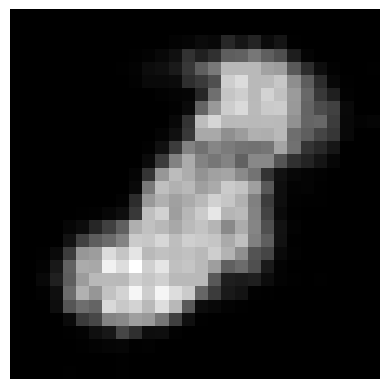

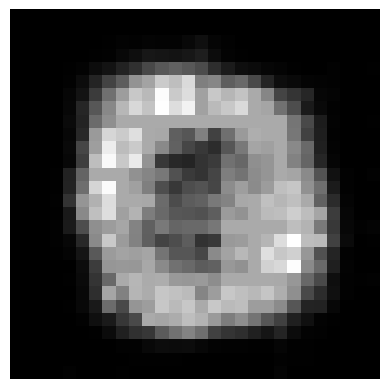

In [10]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

with torch.no_grad():
    generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

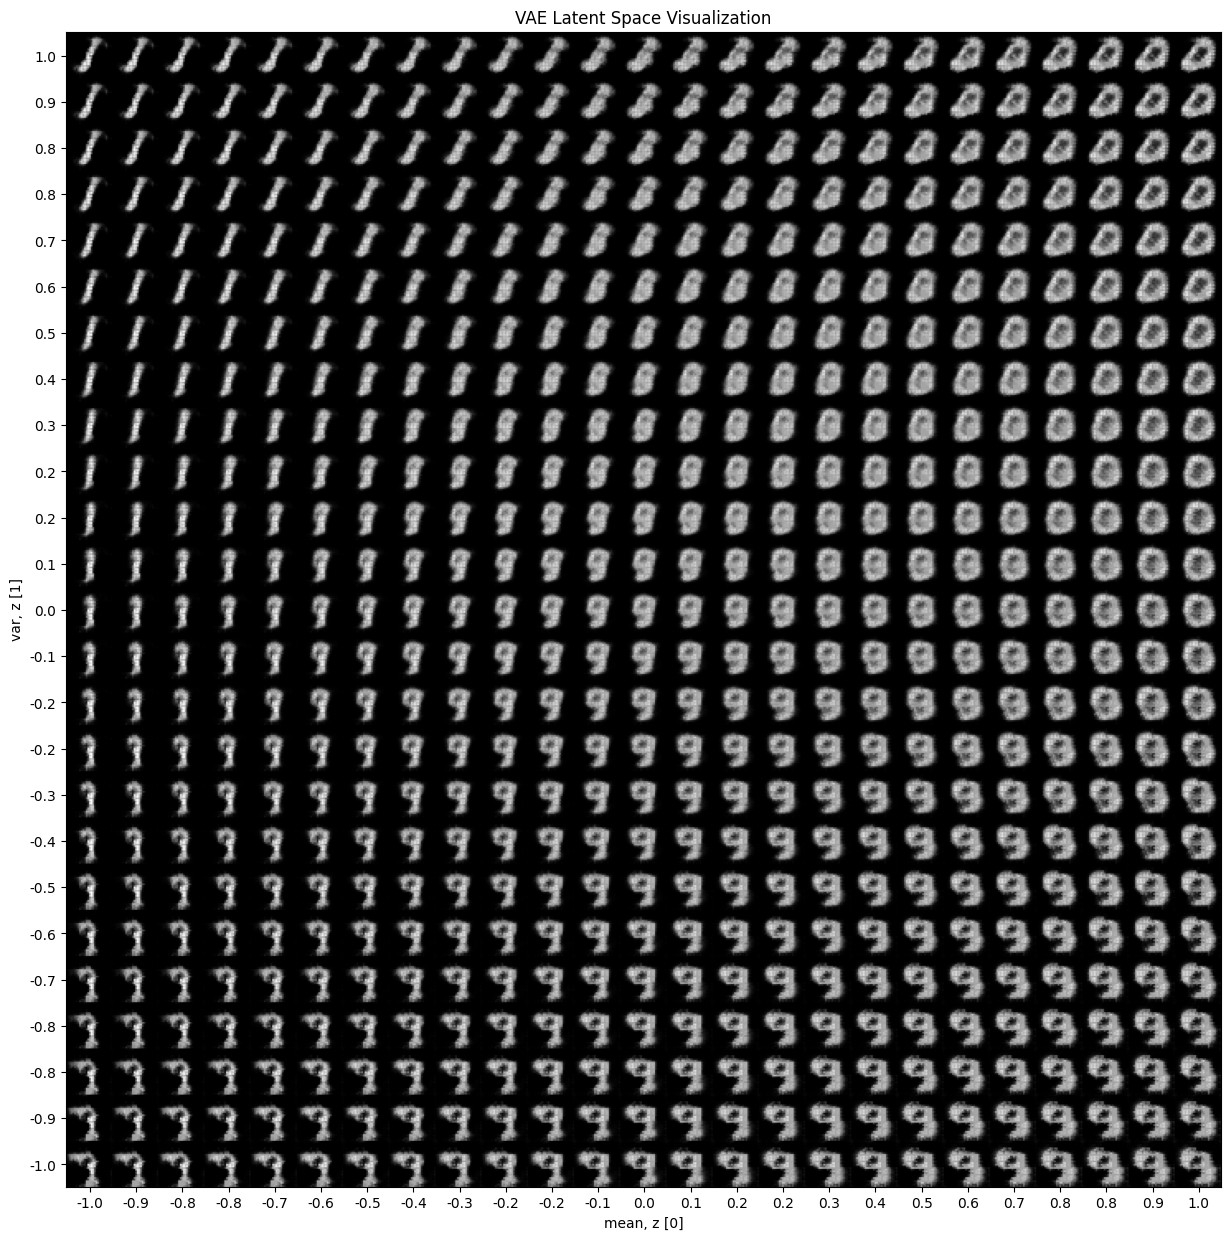

In [11]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

with torch.no_grad():
    plot_latent_space(model)

In [12]:
for x,_ in test_loader:
    x = x.view(batch_size, x_dim).to(device)
    x_hat, mean, log_var = model(x)
    digits = x_hat.detach().cpu().reshape(100, 28, 28) # reshape vector to 2d array
    digit_1 = digits[0, :, :]
    plt.imshow(digits[0, :, :], cmap='gray')
    plt.axis('off')
    plt.show()
    break

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1024, 784]

In [ ]:
for x,_ in test_loader:
    x = x.view(x.size(0), 1, 28, 28).to(device)
    x_hat, mean, log_var = model(x)
    digits = x_hat.detach().cpu().reshape(100, 28, 28) # reshape vector to 2d array
    digit_2 = digits[0, :, :]
    plt.imshow(digits[0, :, :], cmap='gray')
    plt.axis('off')
    plt.show()
    break

In [ ]:
(digit_1 - digit_2).sum().sum()